# Tutorial - basic example of all metrics

This notebook shows the functionality of the various metrics included in the library. 

For this purpose, we use a pre-trained PyTorch ResNet-18 model and subset of ImageNet dataset.

Skip running this cell, if not using colab

In [ ]:
# Mount Google Drive.
from google.colab import drive
import sys
drive.mount('/content/drive', force_remount=True)
path = "/content/drive/MyDrive/Projects"
sys.path.append(f'{path}/quantus')

In [27]:
# Imports general.
from IPython.display import clear_output
import ast
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import PIL
from tqdm.auto import tqdm
import torch
import torchvision
from torchvision import transforms
import quantus

%load_ext autoreload
%autoreload 2
clear_output()

In [72]:
# Collect garbage.
gc.collect()

1169

Download dataset

In [1]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
!tar zxf imagenette2-320.tgz
clear_output()
!ls imagenette2-320/train/n01440764 | head

ILSVRC2012_val_00000293.JPEG
ILSVRC2012_val_00002138.JPEG
ILSVRC2012_val_00003014.JPEG
ILSVRC2012_val_00006697.JPEG
ILSVRC2012_val_00007197.JPEG
ILSVRC2012_val_00009346.JPEG
ILSVRC2012_val_00009379.JPEG
ILSVRC2012_val_00009396.JPEG
ILSVRC2012_val_00010306.JPEG
ILSVRC2012_val_00011233.JPEG


Download name mapping

In [2]:
!wget https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt -O class_names.txt

--2022-09-09 20:57:46--  https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30564 (30K) [text/plain]
Saving to: ‘class_names.txt’

class_names.txt     100%[===================>]  29.85K  --.-KB/s    in 0.003s  

2022-09-09 20:57:46 (8.69 MB/s) - ‘class_names.txt’ saved [30564/30564]



Select hardware acceleration if available

In [3]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    # Configs torch (read more on this cuda-related issue here: https://github.com/pytorch/pytorch/issues/45769).
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    # More about MPS acceleration here: https://pytorch.org/docs/stable/notes/mps.html
    device = torch.device("mps")
else:
    device = torch.device("cpu")

device

device(type='mps')

## 1. Preliminaries

### 1.1 Load datasets

We will then load a batch of input, output pairs that we generate explanations for, then to evaluate.

In [4]:
# Load name mapping
with open('class_names.txt') as fIn:
  class_name_dict = ast.literal_eval(fIn.read())

In [5]:
# For the localisation metrics we need to load a dataset that has ground truth masks.

def load_sample(path: str) -> dict:
    """Read data as image and path. """
    return PIL.Image.open(path).convert("RGB")


class CustomTransform(torch.nn.Module):
    """Custom transformation to handle image processing and binary mask processing simultaneously. """

    image_transform = transforms.Compose([transforms.Resize((224, 224)),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    def __init__(self, path):
        super().__init__()
        self.path = path

    def __call__(self, img):
        return self.image_transform(img)


class_dict = {
    'n01440764':0,
    'n02102040':217,
    'n02979186':481,
    'n03000684':491,
    'n03028079':497,
    'n03394916':566,
    'n03417042':569,
    'n03425413':571,
    'n03445777':574,
    'n03888257':701
}
class_dirs = list(class_dict.keys())

def verify_file(path):
  return path[-5:]==".JPEG"
#extensions=("JPEG",),

def transform_labels(l):
  new_l = class_dict[class_dirs[l]]
  #print(new_l)
  return new_l

# Load test data and make loaders.
path_data = 'imagenette2-320/train'
dataset = torchvision.datasets.DatasetFolder(path_data,
                                             loader=load_sample,
                                             is_valid_file=verify_file,
                                             transform=CustomTransform(path=path_data),
                                             target_transform=transform_labels)
test_loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=24)

In [6]:
# Load a batch of inputs, segmentation masks and outputs to use for evaluation.
x_batch, y_batch = iter(test_loader).next()
x_batch_device, y_batch_device = x_batch.to(device), y_batch.to(device)
x_batch.shape

torch.Size([24, 3, 224, 224])

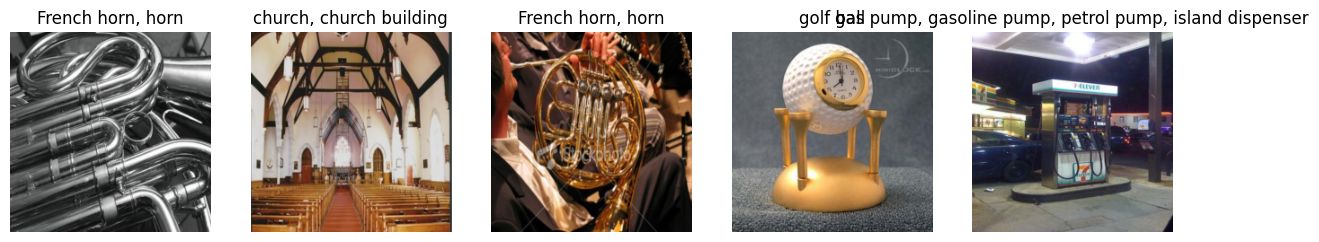

In [7]:
# Plot some inputs!

nr_images = 5
fig, axes = plt.subplots(nrows=1, ncols=nr_images, figsize=(nr_images*3, int(nr_images*2/3)))
for i in range(nr_images):
    axes[i].imshow((np.moveaxis(quantus.denormalise(x_batch[i].numpy()), 0, -1) * 255).astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
    axes[i].title.set_text(f"{class_name_dict[y_batch[i].item()]}")
    axes[i].axis("off")
plt.show()

### 1.2 Load a pre-trained model

In this example we load a pre-trained ResNet-18 model but it goes without saying that any model works.

In [68]:
# Load pre-trained ResNet18 model.
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
model.training = False
model = model.to(device)

### 1.3 Generate attribution-based explanations

There exist multiple ways to generate explanations for neural network models e.g., using `captum` or `innvestigate` libraries. In this example, we rely on the `quantus.explain` functionality (a simple wrapper around `captum`) however use whatever approach or library you'd like to create your explanations.

**Requirements.**

* **Data type.** Similar to the x-y pairs, the attributions should also be of type `np.ndarray`
* **Shape.** Sharing all the same dimensions as the input (expect for nr_channels which for explanations is equal to 1). For example, if x_batch is of size (128, 3, 224, 224) then the attributions should be of size (128, 1, 224, 224).

In [8]:
# Generate Integrated Gradients attributions of the first batch of the test set.
a_batch = quantus.explain(model, x_batch, y_batch, method="IntegratedGradients", normalise=True)

# Save x_batch and y_batch as numpy arrays that will be used to call metric instances.
x_batch, s_batch, y_batch = x_batch.cpu().numpy(), s_batch.cpu().numpy(), y_batch.cpu().numpy()

# Make sure s_batch is of correct shape.
s_batch = s_batch.reshape(len(x_batch), 1, 224, 224)

# Quick assert.
assert [isinstance(obj, np.ndarray) for obj in [x_batch, y_batch, s_batch, a_batch]]

Visulise attributions given model and pairs of input-output.

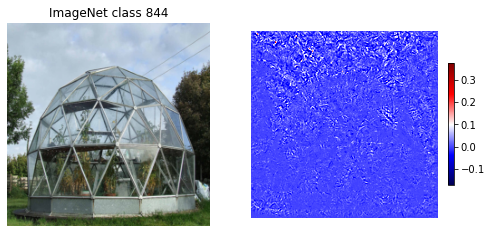

In [9]:
index = random.randint(0, len(x_batch)-1)

# Plot examplary explanations!
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
axes[0].imshow(np.moveaxis(quantus.denormalise(x_batch[index], **{"img_size": 224}), 0, -1), vmin=0.0, vmax=1.0)
axes[0].title.set_text(f"ImageNet class {y_batch[index].item()}")
exp = axes[1].imshow(a_batch[index].reshape(224, 224), cmap="seismic") 
fig.colorbar(exp, fraction=0.03, pad=0.05); 
axes[0].axis("off"); axes[1].axis("off"); plt.show()

## 2. Evaluation using `Quantus`

As a preliminary step to evaluating the explanations using all the available metrics in the library, we will first view what categories and metrics we have available.

In [9]:
# Let's view what metrics categories are available.
quantus.available_categories()

['Faithfulness',
 'Robustness',
 'Localisation',
 'Complexity',
 'Randomisation',
 'Axiomatic']

In [10]:
# In each category, let's view the available metrics.
metrics = quantus.available_metrics()
metrics

{'Faithfulness': ['Faithfulness Correlation',
  'Faithfulness Estimate',
  'Pixel-Flipping',
  'Region Segmentation',
  'Monotonicity-Arya',
  'Monotonicity-Nguyen',
  'Selectivity',
  'SensitivityN',
  'IROF',
  'ROAD',
  'Infidelity',
  'Sufficiency'],
 'Robustness': ['Continuity Test',
  'Local Lipschitz Estimate',
  'Max-Sensitivity',
  'Avg-Sensitivity',
  'Consistency',
  'Relative Input Stability',
  'Relative Representation Stability',
  'Relative Output Stability'],
 'Localisation': ['Pointing Game',
  'Top-K Intersection',
  'Relevance Mass Accuracy',
  'Relevance Rank Accuracy',
  'Attribution Localisation ',
  'AUC',
  'Focus'],
 'Complexity': ['Sparseness', 'Complexity', 'Effective Complexity'],
 'Randomisation': ['Model Parameter Randomisation', 'Random Logit'],
 'Axiomatic': ['Completeness', 'NonSensitivity', 'InputInvariance']}

### 2.1 Faithfulness metrics 

Score explanations using the following faithfulness metrics:

* Faithfulness Correlation (Bhatt et al., 2020)
* Faithfulness Estimate (Alvarez-Melis et al., 2018, 2019)
* Pixel-Flipping (Bach et al., 2015)
* Region Segmentation (Samek et al., 2015)
* Monotonicity-Arya (Arya et al., 2019)
* Monotonicity-Nguyen (Nguyen et al., 2019)
* Selectivity (Montavan et al., 2018)
* SensitivityN (Ancona et al., 2018)
* IROF (Rieger et al., 2020)
* Infidelity (Yeh et al., 2019)
* ROAD  (Rong, Leehmann et al., 2022)
* Sufficiency (Dasgupta et al., 2022)

In [ ]:
# Return faithfulness correlation scores in an one-liner - by calling the metric instance.
quantus.FaithfulnessCorrelation(**{
    "nr_runs": 100,  
    "subset_size": 224,  
    "perturb_baseline": "black",
    "perturb_func": quantus.baseline_replacement_by_indices,
    "similarity_func": quantus.correlation_pearson,  
    "abs": False,  
    "return_aggregate": False,
})(model=model, 
   x_batch=x_batch, 
   y_batch=y_batch,
   a_batch=a_batch,
   **{"device": device})

Warnings and information:
 (1) The Faithfulness Correlation metric is likely to be sensitive to the choice of baseline value 'perturb_baseline', size of subset |S| 'subset_size' and the number of runs (for each input and explanation pair) 'nr_runs'. 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Bhatt, Umang, Adrian Weller, and José MF Moura. 'Evaluating and aggregating feature-based model explanations.' arXiv preprint arXiv:2005.00631 (2020).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.


[-0.19827157562844644,
 0.0054403553916248255,
 -0.2027064255479862,
 -0.07202830993834358,
 -0.12918910833574773,
 0.13814105354476744,
 0.07023196388594861,
 -0.01911785749822729,
 -0.18462865023311598,
 -0.06862724626969977,
 0.031087324361764365,
 0.0012688695096614614,
 -0.006769303568648453,
 -0.10674796549732535,
 0.07177501190892192,
 0.19889133390912922]

In [ ]:
# Return faithfulness estimate scores in an one-liner - by calling the metric instance.
quantus.FaithfulnessEstimate(**{
    "perturb_func": quantus.baseline_replacement_by_indices,
    "similarity_func": quantus.correlation_pearson,
    "features_in_step": 224,  
    "perturb_baseline": "black",  
    "pixels_in_step": 28,
})(model=model, 
   x_batch=x_batch, 
   y_batch=y_batch,
   a_batch=a_batch,
   **{"device": device})

Warnings and information:
 (1) The Faithfulness Estimate metric is likely to be sensitive to the choice of baseline value 'perturb_baseline' and similarity function 'similarity_func'. 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Alvarez-Melis, David, and Tommi S. Jaakkola. 'Towards robust interpretability with self-explaining neural networks.' arXiv preprint arXiv:1806.07538 (2018).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.


[-0.07237356317851067,
 -0.16208607696482946,
 -0.19047020249224017,
 -0.29160647754485336,
 -0.3255894721958304,
 0.10070019399075614,
 -0.003911988318044315,
 -0.20038300351953564,
 -0.0886730578145982,
 -0.3855611147938333,
 -0.45271396123043117,
 -0.21915935636106923,
 -0.2876209648731882,
 -0.5022147406395353,
 -0.006866152993775278,
 -0.4336312471425027]

In [ ]:
# Return monotonicity scores in an one-liner - by calling the metric instance.
quantus.MonotonicityArya(**{
    "features_in_step": 224,
    "perturb_baseline": "black",
    "perturb_func": quantus.baseline_replacement_by_indices,
    "similarity_func": quantus.correlation_spearman,
})(model=model, 
   x_batch=x_batch, 
   y_batch=y_batch,
   a_batch=a_batch,
   **{"device": device})

Warnings and information:
 (1) The Monotonicity Arya metric is likely to be sensitive to the choice of baseline value 'perturb_baseline'. 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Arya, Vijay, et al. 'One explanation does not fit all: A toolkit and taxonomy of ai explainability techniques.' arXiv preprint arXiv:1909.03012 (2019).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.


[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [ ]:
# Return monotonicity scores in an one-liner - by calling the metric instance.
quantus.MonotonicityNguyen(**{
    "nr_samples": 10,
    "features_in_step": 3136,
    "perturb_baseline": "uniform",
    "perturb_func": quantus.baseline_replacement_by_indices,
    "similarity_func": quantus.correlation_spearman,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=a_batch,
   **{"device": device})

Warnings and information:
 (1) The Monotonicity Nguyen metric is likely to be sensitive to the choice of baseline value 'perturb_baseline', threshold value 'eps' and number of samples to iterate over 'nr_samples'. 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Nguyen, An-phi, and María Rodríguez Martínez. 'On quantitative aspects of model interpretability.' arXiv preprint arXiv:2007.07584 (2020).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.


[0.6941176470588235,
 -0.4088235294117647,
 0.44705882352941173,
 -0.35000000000000003,
 0.44117647058823534,
 0.5323529411764706,
 0.7794117647058825,
 -0.3,
 0.5323529411764706,
 0.5823529411764706,
 0.7764705882352941,
 -0.21470588235294116,
 -0.7941176470588236,
 0.9,
 -0.047058823529411764,
 0.2735294117647059]

Warnings and information:
 (1) The Pixel Flipping metric is likely to be sensitive to the choice of baseline value 'perturb_baseline'. 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Bach, Sebastian, et al. 'On pixel-wise explanations for non-linear classifier decisions by layer - wise relevance propagation.' PloS one 10.7 (2015) e0130140.
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.


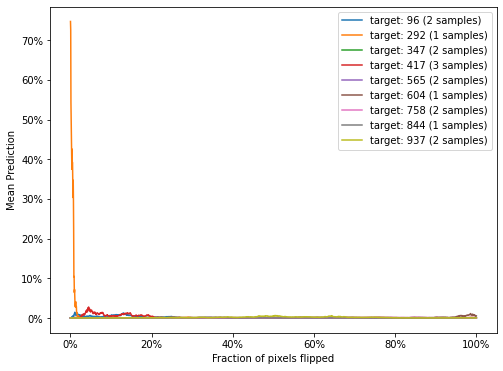

In [ ]:
# Create the pixel-flipping experiment.
pixel_flipping = quantus.PixelFlipping(**{
    "features_in_step": 224,
    "perturb_baseline": "black",
    "perturb_func": quantus.baseline_replacement_by_indices,
})
    
# Call the metric instance to produce scores.
scores = pixel_flipping(model=model,
                        x_batch=x_batch,
                        y_batch=y_batch,
                        a_batch=a_batch,
                        **{"device": device})

# Plot example!
pixel_flipping.plot(y_batch=y_batch, scores=scores)

Warnings and information:
 (1) The Region Perturbation metric is likely to be sensitive to the choice of baseline value 'perturb_baseline', the patch size for masking 'patch_size' and number of regions to evaluate 'regions_evaluation'. 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Samek, Wojciech, et al. 'Evaluating the visualization of what a deep neural network has learned.' IEEE transactions on neural networks and learning systems 28.11 (2016): 2660-2673.
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.



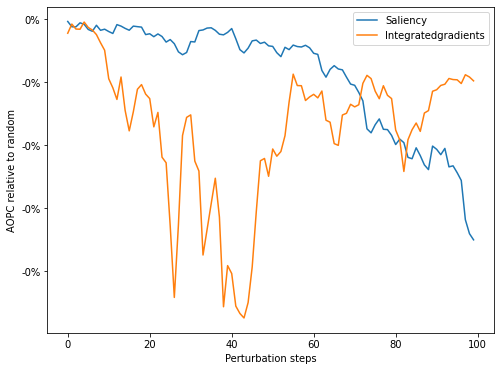

In [ ]:
# Create the region perturbation experiment.
region_perturb = quantus.RegionPerturbation(**{
    "patch_size": 28,
    "regions_evaluation": 100,
    "perturb_baseline": "uniform",  
    "normalise": True,
})
    
# Call the metric instance to produce scores.
results = {method: region_perturb(model=model, 
                                  x_batch=x_batch,
                                  y_batch=y_batch,
                                  a_batch=None,
                                  **{"explain_func": quantus.explain, "method": method, "device": device}) for method in ["Saliency", "IntegratedGradients"]}

# Plot example!
region_perturb.plot(results=results)

In [11]:
# Create the selectivity experiment.
selectivity = quantus.Selectivity(**{
    "patch_size": 28,
    "perturb_baseline": "black",  
})
    
# Call the metric instance to produce scores.
results = {method: selectivity(model=model, 
                               x_batch=x_batch,
                               y_batch=y_batch,
                               a_batch=None,
                               **{"explain_func": quantus.explain, "method": method, "device": device}) for method in ["Saliency", "IntegratedGradients"]}

# Plot example!
#selectivity.plot(results=results)
results

Warnings and information:
 (1) The Selectivity metric is likely to be sensitive to the choice of baseline value 'perturb_baseline' and the patch size for masking 'patch_size'. 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Montavon, Grégoire, Wojciech Samek, and Klaus-Robert Müller. 'Methods for interpreting and understanding deep neural networks.' Digital Signal Processing 73 (2018): 1-15.
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.



/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


{'IntegratedGradients': {0: [1.687935480276792e-08,
   1.3136863152851674e-08,
   1.2774028945727878e-08,
   1.1205448124940176e-08,
   1.1829358825821146e-08,
   1.6926225754332336e-08,
   1.4577766549450644e-08,
   2.6256493868004327e-08,
   2.6620368132057592e-08,
   2.3032404428136033e-08,
   2.9974401627441694e-08,
   3.590541197695529e-08,
   3.7324564772234226e-08,
   3.782409052632829e-08,
   4.272761344736864e-08,
   3.9512116245532525e-08,
   8.814338059437432e-08,
   5.458619156684108e-08,
   5.651035195342047e-08,
   8.135589979474389e-08,
   8.941990614630413e-08,
   1.0295759977907437e-07,
   1.6216554854509013e-07,
   1.4093298261741438e-07,
   1.2663255688494246e-07,
   1.4425002348161797e-07,
   1.1872642602384076e-07,
   7.360196008221465e-08,
   1.0402700922895747e-07,
   1.3216637739787984e-07,
   1.8799840972860693e-07,
   1.712710542278728e-07,
   1.5654322282898647e-07,
   1.8586598571346258e-07,
   2.194600483562681e-07,
   2.3417068462094903e-07,
   2.477118243

In [ ]:
# Create the sensitivity-n experiment.
sensitivity_n = quantus.SensitivityN(**{
    "features_in_step": 224,
    "n_max_percentage": 0.8,
    "similarity_func": quantus.correlation_pearson,
    "perturb_func": quantus.baseline_replacement_by_indices,
    "perturb_baseline": "uniform",  
    "return_aggregate" : False,
})
# Call the metric instance to produce scores.
results = sensitivity_n(model=model, 
                        x_batch=x_batch,
                        y_batch=y_batch,
                        a_batch=None,
                        **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

# Plot example!
# TODO. The curves looks different than in paper?
#sensitivity_n.plot(results=results)
results

Warnings and information:
 (1) The Sensitivity N metric is likely to be sensitive to the choice of baseline value 'perturb_baseline', the patch size for masking 'patch_size', similarity function 'similarity_func' and the number of features to iteratively evaluate 'n_max_percentage'. 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Ancona, Marco, et al. 'Towards better understanding of gradient-based attribution methods for deep neural networks.' arXiv preprint arXiv:1711.06104 (2017).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.



[-0.0347195051451471,
 -0.1360993226786156,
 -0.1199987529564489,
 -0.10507309165452404,
 -0.10538607130412181,
 0.17760349725168179,
 0.16620556389518273,
 0.09717156475973636,
 0.2043963205839478,
 0.13675702334214707,
 0.05354554183352314,
 0.0915868033501377,
 0.1104840039428652,
 0.17251515105332094,
 -0.07514138038555539,
 -0.08308832478693283,
 -0.13600038294005318,
 -0.14647693268868825,
 -0.10132398660966516,
 -0.0967066382092122,
 -0.0610953767754293,
 -0.0696940178157888,
 -0.16144497155056442,
 -0.17545448373230826,
 -0.1822262680311447,
 -0.15507695210604078,
 -0.21076271016796877,
 -0.19382145864575492,
 -0.20271300523335492,
 -0.22659343628655984,
 -0.24544590660776286,
 -0.24373477822524572,
 -0.24750704288686418,
 -0.25048628843971693,
 -0.24734985501278345,
 -0.263910410687905,
 -0.2611937806516914,
 -0.26569831256121823,
 -0.26462158640443456,
 -0.2783362754628455,
 -0.28543006263224385,
 -0.28867647932657037,
 -0.289933821797459,
 -0.2884906459755521,
 -0.2823437057

In [16]:
# Return IFOF scores in an one-liner - by calling the metric instance.
scores = {method: quantus.IterativeRemovalOfFeatures(**{
    "segmentation_method": "slic",
    "perturb_baseline": "mean",
    "perturb_func": quantus.baseline_replacement_by_indices,
    "return_aggregate": False,
})(model=model,
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": method, "device": device}) for method in ["Gradient", "Saliency", "IntegratedGradients", "GradientShap"]}

scores # felzenswalb

Warnings and information:
 (1) The Iterative Removal Of Features metric is likely to be sensitive to the choice of baseline value 'perturb_baseline' and the method to segment the image 'segmentation_method' (including all its associated hyperparameters). 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Rieger, Laura, and Lars Kai Hansen. 'Irof: a low resource evaluation metric for explanation methods.' arXiv preprint arXiv:2003.08747 (2020).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.



/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


Warnings and information:
 (1) The Iterative Removal Of Features metric is likely to be sensitive to the choice of baseline value 'perturb_baseline' and the method to segment the image 'segmentation_method' (including all its associated hyperparameters). 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Rieger, Laura, and Lars Kai Hansen. 'Irof: a low resource evaluation metric for explanation methods.' arXiv preprint arXiv:2003.08747 (2020).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.

Warnings and information:
 (1) The Iterative Removal Of Features metric is likely to be sensitive to the choice of baseline value 'perturb_baseline' an

{'Gradient': [-3383.207272199855,
  -2427.4386377178125,
  -27.03594310599503,
  -35.84884453151828,
  -87.70336326442717,
  -28.567135083121805,
  -406.2916855802101,
  -30.38094641747537,
  9.553858929610975,
  -266.0758014715309,
  -15.881283134151325,
  -10.455719151547555,
  -17.07945002158675,
  -66.27510064575162],
 'GradientShap': [-3383.3558849260075,
  -2427.216408357823,
  -25.742689880266383,
  -37.18563487739823,
  -88.85301846979903,
  -28.864239268655744,
  -408.2620074261094,
  -30.38688345733476,
  9.32020002202212,
  -265.867129308026,
  -15.655034200725616,
  -10.86531790982648,
  -17.185116487852895,
  -55.22831645914552],
 'IntegratedGradients': [-3383.5562061375617,
  -2424.503581896012,
  -25.762376211807535,
  -37.15416811116509,
  -88.41853853556961,
  -26.561872962010064,
  -409.36006108645944,
  -30.19708069730295,
  9.657847796842596,
  -265.25121498085696,
  -15.099488767779036,
  -10.790514302620082,
  -17.185116487852895,
  -54.99726077273043],
 'Saliency

In [66]:
# Return Infidelity scores in an one-liner - by calling the metric instance.
quantus.Infidelity(**{
    "perturb_baseline": "uniform",
    "perturb_func": quantus.baseline_replacement_by_indices,
    "n_perturb_samples": 10,
    "perturb_patch_sizes": [14], 
    "display_progressbar": True,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
  **{"explain_func": quantus.explain, "method": "Saliency", "device": device})

Warnings and information:
 (1) The Infidelity metric is likely to be sensitive to the choice of baseline value 'perturb_baseline', perturbation function 'perturb_func',number of perturbed samples 'n_perturb_samples', the loss function 'loss_func' aggregation boolean 'aggregate'. 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Chih-Kuan, Yeh, et al. 'On the (In)fidelity and Sensitivity of Explanations'arXiv:1901.09392 (2019).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.



/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
Evaluation of Infidelity: 100%|██████████| 16/16 [1:01:49<00:00, 231.82s/it]


[888162239.3036783,
 2102579394.0102158,
 738508338.8220133,
 6989403754.564344,
 3000943596.9719543,
 900293084.4338617,
 144327936.90917924,
 83946936.94424546,
 7476661153.816933,
 59742666356.715004,
 617563252.4456885,
 3995147061.179788,
 163460191.55734968,
 15220898393.094137,
 1666995371.7933817,
 98355522.96653223]

In [65]:
# Return ROAD scores in an one-liner - by calling the metric instance.
quantus.ROAD(**{
    "noise": 0.01,
    "perturb_func": quantus.noisy_linear_imputation,
    "percentages": list(range(1, 100, 2)),
    "display_progressbar": False,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=a_batch,
   **{"device": device})

Warnings and information:
 (1) The ROAD metric is likely to be sensitive to the choice of baseline value 'perturb_baseline', perturbation function 'perturb_func',percentage of pixels k removed per iteration 'percentage_in_step'. 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Rong, Leemann, et al. 'Evaluating Feature Attribution: An Information-Theoretic Perspective.' arXiv:2202.00449 (2022).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.



[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [17]:
 # Return Sufficiency scores in an one-liner - by calling the metric instance.
quantus.Sufficiency(**{
    "threshold": 0.6,
    "return_aggregate": False,
})(model=model,
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=a_batch,
   **{"device": device})

Warnings and information:
 (1) The Sufficiency metric is likely to be sensitive to the choice of distance threshold that determines if images share an attribute 'threshold', distance function 'distance_func'. 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Sanjoy Dasgupta, Nave Frost, and Michal Moshkovitz. 'Framework for Evaluating Faithfulness of Explanations.' arXiv preprint arXiv:2202.00734 (2022)..
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.



[0.0,
 0.25,
 0.09090909090909091,
 0.125,
 0.0,
 0.16666666666666666,
 0.2727272727272727,
 0.0,
 0.0,
 0.0,
 0,
 0.0,
 0,
 0.2]

### 2.2 Robustness metrics 

Score explanations using the following robustness metrics:

* Local Lipschitz Estimate (Alvarez-Melis et al., 2018; 2019)
* Max-Sensitivity (Yeh at el., 2019)
* Avg-Sensitivity (Yeh at el., 2019)
* Continuity (Montavan et al., 2017)
* Input Independence Rate (Yang et al., 2019)
* Consistency (Dasgupta et al., 2022)

In [ ]:
# Return local lipschitzEstimate estimate scores in an one-liner - by calling the metric instance.
quantus.LocalLipschitzEstimate(**{
    "nr_samples": 10,
    "perturb_std": 0.1,
    "perturb_mean": 0.1,
    "norm_numerator": quantus.distance_euclidean,
    "norm_denominator": quantus.distance_euclidean,    
    "perturb_func": quantus.gaussian_noise,
    "similarity_func": quantus.lipschitz_constant,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "Saliency", "device": device})

Warnings and information:
 (1) The Local Lipschitz Estimate metric is likely to be sensitive to the choice of amount of noise added 'perturb_std', the number of samples iterated over 'nr_samples', the function to perturb the input 'perturb_func', the similarity metric 'similarity_func' as well as norm calculations on the numerator and denominator of the lipschitz equation i.e., 'norm_numerator' and 'norm_denominator'. 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Alvarez-Melis, David, and Tommi S. Jaakkola. 'On the robustness of interpretability methods.' arXiv preprint arXiv:1806.08049 (2018). and Alvarez-Melis, David, and Tommi S. Jaakkola. 'Towards robust interpretability wi

[43.865781690118666,
 51.52660160431735,
 43.0651450145517,
 72.067773857349,
 68.04078016085002,
 53.01732697680634,
 58.444292055182274,
 49.23399056292648,
 49.05160468451455,
 65.527108030165,
 50.68520159051867,
 44.2269132482767,
 55.56497720452099,
 55.51123121798976,
 23.952006703732405,
 51.30790025096706,
 81.23196832195968,
 53.102487999141545,
 42.605110316138315]

In [ ]:
# Return max sensitivity scores in an one-liner - by calling the metric instance.
quantus.MaxSensitivity(**{
    "nr_samples": 10,
    "perturb_radius": 0.2,
    "norm_numerator": quantus.fro_norm,
    "norm_denominator": quantus.fro_norm,
    "perturb_func": quantus.uniform_noise,
    "similarity_func": quantus.difference,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "Saliency", "device": device})

Warnings and information:
 (1) The Max Sensitivity metric is likely to be sensitive to the choice of amount of noise added 'lower_bound' and 'upper_bound', the number of samples iterated over 'nr_samples', the function to perturb the input 'perturb_func', the similarity metric 'similarity_func' as well as norm calculations on the numerator and denominator of the sensitivity equation i.e., 'norm_numerator' and 'norm_denominator'. 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Yeh, Chih-Kuan, et al. 'On the (in) fidelity and sensitivity for explanations.' arXiv preprint arXiv:1901.09392 (2019).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metr

[0.012076403,
 0.007863087,
 0.00653575,
 0.011230776,
 0.018137272,
 0.04448305,
 0.016040895,
 0.01050691,
 0.005378844,
 0.0057157134,
 0.0066819973,
 0.0062388023,
 0.015636664,
 0.0064164554,
 0.015252533,
 0.00556414,
 0.008693955,
 0.007968955,
 0.0033015811]

In [ ]:
# Return avg sensitivity scores in an one-liner - by calling the metric instance.
quantus.AvgSensitivity(**{
    "nr_samples": 10,
    "perturb_radius": 0.2,
    "norm_numerator": quantus.fro_norm,
    "norm_denominator": quantus.fro_norm,
    "perturb_func": quantus.uniform_noise,
    "similarity_func": quantus.difference,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "Saliency", "device": device})

Warnings and information:
 (1) The Avg Sensitivity metric is likely to be sensitive to the choice of amount of noise added 'lower_bound' and 'upper_bound', the number of samples iterated over 'nr_samples', the function to perturb the input 'perturb_func', the similarity metric 'similarity_func' as well as norm calculations on the numerator and denominator of the sensitivity equation i.e., 'norm_numerator' and 'norm_denominator'. 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Yeh, Chih-Kuan, et al. 'On the (in) fidelity and sensitivity for explanations.' arXiv preprint arXiv:1901.09392 (2019).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metr

[0.01120995543897152,
 0.007414987776428461,
 0.006237388588488102,
 0.010716255754232407,
 0.017975693568587303,
 0.04218230023980141,
 0.015786880627274513,
 0.009884173050522804,
 0.005176178179681301,
 0.005641050171107054,
 0.0062997713685035706,
 0.0060018268413841724,
 0.015499234199523926,
 0.006172256078571081,
 0.014597797766327858,
 0.00516583351418376,
 0.00809464044868946,
 0.007618231233209372,
 0.003119800705462694]

In [ ]:
# Return continuity scores in an one-liner - by calling the metric instance.
continuity_test = quantus.Continuity(**{
    "nr_patches": 4,
    "nr_steps": 10,
    "perturb_baseline": "uniform",
    "similarity_func": quantus.correlation_spearman,
    #"img_size": 224, 
})
scores = continuity_test(model=model, 
                         x_batch=x_batch,
                         y_batch=y_batch,
                         a_batch=None,
                         **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

#print(f"Continuity correlation score: {continuity_test.aggregated_score:.4f}")
scores

Warnings and information:
 (1) The Continuity metric is likely to be sensitive to the choice of how many patches to split the input image to 'nr_patches', the number of steps to iterate over 'nr_steps', the value to replace the masking with 'perturb_baseline' and in what direction to translate the image 'perturb_func'. 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Montavon, Grégoire, Wojciech Samek, and Klaus-Robert Müller. 'Methods for interpreting and understanding deep neural networks.' Digital Signal Processing 73, 1-15 (2018.
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.



{0: {0: [2.7114948891103268,
   4.298794269561768,
   4.252630740404129,
   3.501242145895958,
   3.6014410257339478,
   3.34322527423501,
   4.449938736855984,
   3.1776324287056923,
   3.391725979745388,
   4.223123900592327],
  1: [3.575547119602561,
   3.1155384480953217,
   3.084787145256996,
   3.1484818011522293,
   3.1270257085561752,
   3.1628962457180023,
   3.2062425054609776,
   3.206256315112114,
   3.5348811354488134,
   3.139295060187578],
  2: [2.7956920191645622,
   4.203091040253639,
   3.7565393932163715,
   4.257387265563011,
   3.983512334525585,
   4.067296829074621,
   3.877642586827278,
   3.815810263156891,
   3.9491967111825943,
   3.887292057275772],
  3: [3.3531160186976194,
   4.063223138451576,
   4.18703006207943,
   4.499216377735138,
   4.50799760222435,
   4.648241639137268,
   4.048627246171236,
   4.521186321973801,
   4.118025053292513,
   4.110303219407797],
  4: [2.5989105701446533,
   4.456273108720779,
   4.019024383276701,
   4.185331858694553,

In [35]:
# Return Consistency scores in an one-liner - by calling the metric instance.
quantus.Consistency(**{
    "discretise_func": quantus.rank,
    "return_aggregate": False,
})(model=model,
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "Saliency", "device": device})

Warnings and information:
 (1) The Consistency metric is likely to be sensitive to the choice of Function for discretisation of the explanation space 'discretise_func' (return hash value ofan np.array used for comparison).. 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Sanjoy Dasgupta, Nave Frost, and Michal Moshkovitz. 'Framework for Evaluating Faithfulness of Explanations.' arXiv preprint arXiv:2202.00734 (2022).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.



/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

### 2.3 Localisation metrics

* Pointing Game (Zhang et al., 2018)
* Attribution Localisation (Kohlbrenner et al., 2020)
* TKI (Theiner et al., 2021)
* Relevance Rank Accuracy (Arras et al., 2021)
* Relevance Mass Accuracy (Arras et al., 2021)
* AUC (Arras et al., 2021)

In [ ]:
# Return effective complexity scores in an one-liner - by calling the metric instance.
quantus.PointingGame(**{
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   s_batch=s_batch,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

Warnings and information:
 (1) The Pointing Game metric is likely to be sensitive to the choice of ground truth mask i.e., the 's_batch' input as well as if the attributions are normalised 'normalise' (and 'normalise_func') and/ or taking absolute values of such 'abs'. 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Zhang, Jianming, Baral, Sarah Adel, Lin, Zhe, Brandt, Jonathan, Shen, Xiaohui, and Sclaroff, Stan. 'Top-Down Neural Attention by Excitation Backprop.' International Journal of Computer Vision, 126:1084-1102 (2018).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.



[True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True]

In [ ]:
# Return attribution localisation scores in an one-liner - by calling the metric instance.
quantus.AttributionLocalisation(**{
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   s_batch=s_batch,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

Warnings and information:
 (1) The Attribution Localisation metric is likely to be sensitive to the choice of ground truth mask i.e., the 's_batch', if size of the ground truth mask is taking into account 'weighted' as well as if attributions are normalised 'normalise' (and 'normalise_func') and/ or taking the absolute values of such 'abs'. 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Kohlbrenner M., Bauer A., Nakajima S., Binder A., Wojciech S., Lapuschkin S. 'Towards Best Practice in Explaining Neural Network Decisions with LRP.arXiv preprint arXiv:1910.09840v2 (2020)..
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.



[0.3752978444099426,
 0.5104113817214966,
 1.0,
 0.6610556840896606,
 0.6565477848052979,
 0.623717725276947,
 0.23087944090366364,
 0.5972482562065125,
 0.9824274778366089,
 0.4724040627479553,
 1.0,
 0.4561261236667633,
 0.14260844886302948,
 0.5601998567581177,
 0.03887507691979408,
 0.9059615731239319,
 0.7105893492698669,
 0.8500680327415466,
 0.05121055245399475,
 0.36244848370552063,
 0.5490319132804871]

In [ ]:
# Return tki scores in an one-liner - by calling the metric instance.
quantus.TopKIntersection(**{
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   s_batch=s_batch,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

Warnings and information:
 (1) The Top K Intersection metric is likely to be sensitive to the choice of ground truth mask i.e., the 's_batch', the number of features to consider 'k', if size of the ground truth mask is taking into account 'concept_influence' as well as if attributions are normalised 'normalise' (and 'normalise_func') and/ or taking absolute values of such 'abs'. 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Theiner, Jonas, Müller-Budack Eric, and Ewerth, Ralph. 'Interpretable Semantic Photo Geolocalization.' arXiv preprint arXiv:2104.14995 (2021).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.



[0.428,
 0.426,
 1.0,
 0.773,
 0.713,
 0.537,
 0.459,
 0.706,
 1.0,
 0.526,
 1.0,
 0.659,
 0.19,
 0.551,
 0.08,
 0.893,
 0.873,
 0.843,
 0.066,
 0.552,
 0.784]

In [ ]:
# Return relevane rank accuracy scores in an one-liner - by calling the metric instance.
quantus.RelevanceRankAccuracy(**{
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   s_batch=s_batch,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

Warnings and information:
 (1) The Relevance Rank Accuracy metric is likely to be sensitive to the choice of ground truth mask i.e., the 's_batch' as well as if the attributions are normalised 'normalise' (and 'normalise_func') and/ or taking absolute values of such 'abs'. 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Arras, Leila, Osman, Ahmed, and Samek, Wojciech. 'Ground Truth Evaluation of Neural Network Explanations with CLEVR-XAI.' arXiv preprint, arXiv:2003.07258v2 (2021)..
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.



[0.3469473684210526,
 0.5318895142952995,
 1.0,
 0.5757451742718778,
 0.6314922204265297,
 0.7498477550794441,
 0.2815934065934066,
 0.535031847133758,
 0.9630663029100529,
 0.4666525781910397,
 1.0,
 0.3707676252319109,
 0.15698615356950188,
 0.5210380835380836,
 0.07583333333333334,
 0.9321771978021978,
 0.6057792207792208,
 0.9308769661710838,
 0.06669691470054447,
 0.31187895212285455,
 0.4037802419354839]

In [ ]:
# Return relevane mass accuracy scores in an one-liner - by calling the metric instance.
quantus.RelevanceMassAccuracy(**{
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   s_batch=s_batch,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

Warnings and information:
 (1) The Relevance Mass Accuracy metric is likely to be sensitive to the choice of ground truth mask i.e., the 's_batch' as well as if the attributions are normalised 'normalise' (and 'normalise_func') and/ or taking absolute values of such 'abs'. 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Arras, Leila, Osman, Ahmed, and Samek, Wojciech. 'Ground Truth Evaluation of Neural Network Explanations with CLEVR-XAI.' arXiv preprint, arXiv:2003.07258v2 (2021)..
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.



[0.37989473,
 0.49970433,
 1.0,
 0.6886155,
 0.54595655,
 0.62841755,
 0.102029555,
 0.5928512,
 0.9886667,
 0.5123167,
 1.0,
 0.42717734,
 0.13565117,
 0.5520872,
 0.02508061,
 0.880198,
 0.71334314,
 0.81667274,
 0.05263738,
 0.41411045,
 0.53604203]

In [ ]:
# Return relevane mass accuracy scores in an one-liner - by calling the metric instance.
quantus.AUC(**{
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   s_batch=s_batch,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

Warnings and information:
 (1) The AUC metric is likely to be sensitive to the choice of ground truth mask i.e., the 's_batch' input as well as if absolute values 'abs' are taken of the attributions . 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Fawcett, Tom. 'An introduction to ROC analysis' Pattern Recognition Letters Vol 27, Issue 8, (2006).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.



[0.5030596215808129,
 0.4988477093373816,
 nan,
 0.4996120394506852,
 0.4994433230294797,
 0.5019037776639019,
 0.5136658631902631,
 0.5009999047394245,
 0.5035615605291596,
 0.5020369103290735,
 nan,
 0.495996947005926,
 0.5011637336864541,
 0.5018678621815408,
 0.4996332812670151,
 0.5062177020301999,
 0.49996070416474525,
 0.4798615757426791,
 0.49377334524994393,
 0.500154212636522,
 0.5004199213765503]

### 2.4 Randomisation metrics

Warnings and information:
 (1) The Model Parameter Randomisation metric is likely to be sensitive to the choice of similarity metric 'similarity_func' and the order of the layer randomisation 'layer_order'. 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Adebayo, J., Gilmer, J., Muelly, M., Goodfellow, I., Hardt, M., and Kim, B. 'Sanity Checks for Saliency Maps.' arXiv preprint, arXiv:1810.073292v3 (2018).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.
Warnings and information:
 (1) The Model Parameter Randomisation metric is likely to be sensitive to the choice of similarity metric 'similarity_func' and the order of the layer randomisa

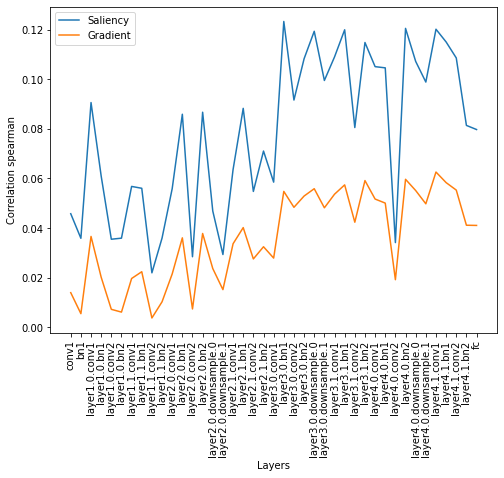

In [ ]:
# Return model parameter randomization scores in an one-liner - by calling the metric instance.
results = {method: quantus.ModelParameterRandomisation(**{
    "layer_order": "bottom_up",
    "similarity_func": quantus.correlation_spearman,
    "normalise": True,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": method, "device": device}) for method in ["Saliency", "Gradient"]}

quantus.plot_model_parameter_randomisation_experiment(results=results, methods=["Saliency", "Gradient"], **{"similarity_metric": quantus.correlation_spearman.__name__.replace("_", " ").capitalize()})

In [ ]:
# Return random logit scores in an one-liner - by calling the metric instance.
quantus.RandomLogit(**{
    "num_classes": 1000,
    "similarity_func": quantus.ssim,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "Saliency", "device": device})

Warnings and information:
 (1) The Random Logit metric is likely to be sensitive to the choice of similarity metric 'similarity_func'. 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Sixt, Leon, Granz, Maximilian, and Landgraf, Tim. 'When Explanations Lie: Why Many Modified BP Attributions Fail.' arXiv preprint, arXiv:1912.09818v6 (2020).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.



[0.7618965152293931,
 0.5504940783362324,
 0.5720013175461991,
 0.560299415000118,
 0.531489377000002,
 0.6057960622890441,
 0.8262798728224001,
 0.5647269989301159,
 0.5887855785402624,
 0.5710104225636247,
 0.6203646054167005,
 0.5124821855047736,
 0.54004454299435,
 0.6410675739095026,
 0.6628263995846659,
 0.7580645053553374,
 0.5818087575220355,
 0.675951498841254,
 0.5359784573450964,
 0.5579483622122396,
 0.7987990215844988]

### 2.5 Complexity metrics

Score explanations using the following complexity metrics:

* Sparseness (Alvarez-Melis et al., 2018; 2019)
* Complexity (Bhatt et al., 2020)
* Effective complexity (Nguyen at el., 2020.)

In [ ]:
# Return sparseness scores in an one-liner - by calling the metric instance.
quantus.Sparseness(**{
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

Warnings and information:
 (1) The Sparseness metric is likely to be sensitive to the choice of normalising 'normalise' (and 'normalise_func') and if taking absolute values of attributions 'abs'. 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Chalasani, Prasad, et al. Concise explanations of neural networks using adversarial training.' International Conference on Machine Learning. PMLR, (2020).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.


[0.5948474137543117,
 0.5701107227744684,
 0.5861066899695018,
 0.5673226598932827,
 0.6183036963165971,
 0.5711496497646923,
 0.6132770540897043,
 0.5795500887698524,
 0.5928359564704174,
 0.5985885195123981,
 0.5554639014679177,
 0.6076942041726541,
 0.5677900017434875,
 0.5951548120737256,
 0.6057108646263357,
 0.5378472020891912]

In [ ]:
# Return complexity scores in an one-liner - by calling the metric instance.
quantus.Complexity(**{
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

Warnings and information:
 (1) The Complexity metric is likely to be sensitive to the choice of normalising 'normalise' (and 'normalise_func') and if taking absolute values of attributions 'abs'. 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Bhatt, Umang, Adrian Weller, and José MF Moura. 'Evaluating and aggregating feature-based model explanations.' arXiv preprint arXiv:2005.00631 (2020).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.


[10.181035400171861,
 10.23999154072575,
 10.21570323701765,
 10.255544474707662,
 10.11868799218763,
 10.242033516259205,
 10.129966489737557,
 10.223786929516208,
 10.201497008180691,
 10.177063776041406,
 10.282180391446035,
 10.156843472100517,
 10.251975244239638,
 10.142111192169605,
 10.159114113002751,
 10.31824972605487]

In [ ]:
# Return effective complexity scores in an one-liner - by calling the metric instance.
quantus.EffectiveComplexity(**{
    "eps": 1e-5,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

### 2.6 Axiomatic metrics

Score explanations using the following axiomatic metrics:

* Completeness (Montavon et al., 2018)
* Non-sensitivity (Nguyen at el., 2020)
* Input Invariance (Kindermans et al., 2017)

In [ ]:
# Return completeness scores in an one-liner - by calling the metric instance.
quantus.Completeness(**{
    "abs": False,
    "disable_warings": True,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=a_batch,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

Warnings and information:
 (1) The Completeness metric is likely to be sensitive to the choice of baseline value 'perturb_baseline' and the function to modify the model response 'output_func'. 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Sundararajan, Mukund, Ankur Taly, and Qiqi Yan. 'Axiomatic attribution for deep networks.' International Conference on Machine Learning. PMLR, (2017)..
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.



[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [ ]:
# Return non-sensitivity scores in an one-liner - by calling the metric instance.
quantus.NonSensitivity(**{
    "abs": True,
    "eps": 1e-5,
    "n_samples": 10, 
    "perturb_baseline": "black",
    "perturb_func": quantus.baseline_replacement_by_indices,
    "features_in_step": 6272,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

Warnings and information:
 (1) The Non Sensitivity metric is likely to be sensitive to the choice of baseline value 'perturb_baseline', the number of samples to iterate over 'n_samples' and the threshold value function for the feature to be considered having an insignificant contribution to the model. 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Nguyen, An-phi, and María Rodríguez Martínez. 'On quantitative aspects of model interpretability.' arXiv preprint arXiv:2007.07584 (2020)..
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.



[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [ ]:
# Return completeness scores in an one-liner - by calling the metric instance.
quantus.InputInvariance(**{
    "abs": False,
    "disable_warings": True,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

Warnings and information:
 (1) The Input Invariance metric is likely to be sensitive to the choice of input shift 'input_shift'. 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Kindermans Pieter-Jan, Hooker Sarah, Adebayo Julius, Alber Maximilian, Schütt Kristof T., Dähne Sven, Erhan Dumitru and Kim Been. 'THE (UN)RELIABILITY OF SALIENCY METHODS' Article (2017)..
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.



[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

## [Relative Stability](https://arxiv.org/pdf/2203.06877.pdf)
RS leverages the changes in explanations, as a subject to change in
- input -> relative input stability
- output logits -> relative output stability
- internal representations -> relative representation stability

In [11]:
x_batch_np = x_batch.numpy()
y_batch_np = y_batch.numpy()
model_wrapper = quantus.get_wrapped_model(model, channel_first=True)

In [12]:
xs_batch = []


for _ in tqdm(range(50)):
    xs = quantus.random_noise(x_batch_np)
    logits = model_wrapper.predict(xs, device=device)
    labels = np.argmax(logits, axis=1)

    same_label_indexes = np.argwhere(labels == y_batch_np)
    xs = xs[same_label_indexes].reshape(-1, *xs.shape[1:])
    xs_batch.append(xs)

# pull all new images into 0 axes
xs_batch = np.vstack(xs_batch)
# drop images, which cause dims not to be divisible
xs_batch = xs_batch[: xs_batch.shape[0] // x_batch.shape[0] * x_batch.shape[0]]
# make xs_batch have the same shape as x_batch, with new batching axis at 0
xs_batch = xs_batch.reshape(-1, *x_batch.shape)
xs_batch.shape

  0%|          | 0/50 [00:00<?, ?it/s]

(29, 24, 3, 224, 224)

In [13]:
as_batch = np.asarray([
    quantus.explain(model, torch.Tensor(i).to(device), y_batch.to(device), method='IntegratedGradients')
    for i in tqdm(xs_batch)
])

  0%|          | 0/29 [00:00<?, ?it/s]

In [15]:
as_batch.shape

(29, 24, 1, 224, 224)

In [16]:
a_batch = quantus.explain(model, x_batch.to(device), y_batch.to(device), method='IntegratedGradients')
a_batch.shape

(24, 1, 224, 224)

In [17]:
rs_eval_params = {
    "normalise": True,
    "abs": True,
    "return_aggregate": True
}
ris = quantus.RelativeInputStability(**rs_eval_params)

ris_result = ris(
    model,
    x_batch=x_batch_np,
    xs_batch=xs_batch,
    a_batch=a_batch,
    as_batch=as_batch,
    y_batch=y_batch_np
)
ris_result

33427.243945402115

In [23]:
ros = quantus.RelativeOutputStability(**rs_eval_params)

ros_result = ros(
    model,
    x_batch=x_batch_np,
    xs_batch=xs_batch,
    a_batch=a_batch,
    as_batch=as_batch,
    y_batch=y_batch_np,
    device=device
)
ros_result

1167549.3103690685

The authors of the RS paper didn’t provide any code examples. Neither did they specify which internal representations to take into account. We expect RRS to be sensitive to this choice. So, let’s try a few options out!
User can provide either layer_names or layer_indices as kwargs, to select, which layers outputs should be taken into account. Providing neither will force usage of all. Warning, this could be really memory consuming for big models, as it relies on keras Functional API to extract features from computational graph. (Which will rebuild the model for each selected output).

In [24]:
layers = [i[0] for i in model.named_modules()]
layers

['',
 'conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer1.0',
 'layer1.0.conv1',
 'layer1.0.bn1',
 'layer1.0.relu',
 'layer1.0.conv2',
 'layer1.0.bn2',
 'layer1.1',
 'layer1.1.conv1',
 'layer1.1.bn1',
 'layer1.1.relu',
 'layer1.1.conv2',
 'layer1.1.bn2',
 'layer2',
 'layer2.0',
 'layer2.0.conv1',
 'layer2.0.bn1',
 'layer2.0.relu',
 'layer2.0.conv2',
 'layer2.0.bn2',
 'layer2.0.downsample',
 'layer2.0.downsample.0',
 'layer2.0.downsample.1',
 'layer2.1',
 'layer2.1.conv1',
 'layer2.1.bn1',
 'layer2.1.relu',
 'layer2.1.conv2',
 'layer2.1.bn2',
 'layer3',
 'layer3.0',
 'layer3.0.conv1',
 'layer3.0.bn1',
 'layer3.0.relu',
 'layer3.0.conv2',
 'layer3.0.bn2',
 'layer3.0.downsample',
 'layer3.0.downsample.0',
 'layer3.0.downsample.1',
 'layer3.1',
 'layer3.1.conv1',
 'layer3.1.bn1',
 'layer3.1.relu',
 'layer3.1.conv2',
 'layer3.1.bn2',
 'layer4',
 'layer4.0',
 'layer4.0.conv1',
 'layer4.0.bn1',
 'layer4.0.relu',
 'layer4.0.conv2',
 'layer4.0.bn2',
 'layer4.0.downsample',
 'layer4.0.down

In [69]:
rrs = quantus.RelativeRepresentationStability(**rs_eval_params)

rrs_result_1 = rrs(
    model,
    x_batch=x_batch_np,
    xs_batch=xs_batch,
    a_batch=a_batch,
    as_batch=as_batch,
    y_batch=y_batch_np,
    device=device,
    layer_names=['layer4.1.conv2']
)
rrs_result_1

17.039144111082877

In [70]:
rrs_result_2 = rrs(
    model,
    x_batch=x_batch_np,
    xs_batch=xs_batch,
    a_batch=a_batch,
    as_batch=as_batch,
    y_batch=y_batch_np,
    device=device,
    layer_indices=[3, 4, 5]
)
rrs_result_2

0.007465076668975073

In [73]:
pd.DataFrame(
    [
        ris_result,
        ros_result,
        rrs_result_1,
        rrs_result_2
    ],
    index=[
        'RIS',
        'ROS',
        'RRS(layer4.1.conv2)',
        'RRS[3, 4, 5]'
    ]
)

,0
RIS,3.342724e+04
ROS,1.167549e+06
RRS(layer4.1.conv2),1.703914e+01
"RRS[3, 4, 5]",7.465077e-03
